In [32]:
import pandas as pd
import ydata_profiling as ydp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from aux_functions.aux_plots import (plot_boxplot_histogram, plot_scatterplot, plot_distribution_actual_predicted)
from aux_functions.statistics import (test_pearson_correlation, apply_linear_regression, evaluate_linear_regression)

# Importing the dataset

In [33]:
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.1,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.8,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.3,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.9,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.2,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


# EDA

## Univariate analysis

### Measures of central tendency and dispersion

In [34]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df.describe()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
count,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0
mean,9.6,53.2,4.4,15.8,81.6,252.2,1.8,2.4,191.4,173.2,43.2
std,1.9,4.5,1.3,10.2,19.4,192.8,0.4,1.0,153.8,139.3,15.2
min,6.7,38.8,1.3,1.6,39.6,29.0,1.0,1.0,20.0,14.0,5.7
25%,8.3,50.9,3.7,8.4,69.5,106.0,2.0,2.0,68.0,66.0,31.4
50%,9.4,53.2,4.4,14.1,82.3,186.0,2.0,2.0,143.0,132.0,42.9
75%,10.5,56.2,5.2,20.3,94.1,312.0,2.0,3.0,252.0,218.0,54.3
max,19.6,65.9,7.8,60.5,133.5,835.0,2.0,4.0,791.0,656.0,80.0


### Boxplots and histograms
* See "./imgs/box_hist" for results

In [35]:
cols = df.columns
for col in cols:
    if col != 'region' and col != 'med_school_affil':
        fig = plot_boxplot_histogram(df[col], col)
        fig.savefig(f'./imgs/box_hist/{col}.png')  # Save the figure

### Testing for normality on infection_risk

In [36]:
norm_test = stats.shapiro(np.array(df['infection_risk']))
print("Statistic of Shapiro Wilk test: ", norm_test.statistic)
print("p-value of Shapiro Wilk test: ", norm_test.pvalue)

Statistic of Shapiro Wilk test:  0.9820429682731628
p-value of Shapiro Wilk test:  0.1338874250650406


- Interpretation of S-W test: Since we had a small sample size, determining the distribution of the variable X was important for choosing an appropriate statistical method. So a Shapiro-Wilk test was performed and did not show evidence of non-normality (W = 0.98, p-value = 0.13).

## Bivariate analysis

### Calculating the correlation matrix

<Axes: >

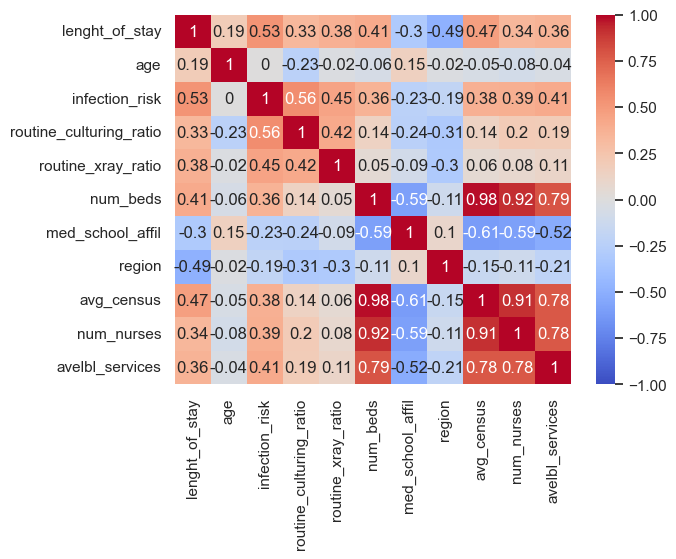

In [37]:
corr_matrix = round(df.corr(),2)
corr_matrix
sns.heatmap(corr_matrix, annot=True, vmin=-1,vmax=1, cmap=sns.color_palette("coolwarm", as_cmap=True))

### Applying a pearson's correlation test

In [38]:
target_variable = 'infection_risk'
for col in ['lenght_of_stay', 'routine_culturing_ratio']:
    pearson_res = test_pearson_correlation(df, col, target_variable)
    print(">> Pearson's correlation result for", col)
    print('Pearsons r:', round(pearson_res.statistic,2), ';', 'pValue:', round(pearson_res.pvalue,3))
    print(pearson_res.confidence_interval()) # Im not sure if this is a 0.95 confidence interval! Weirdly didn't find the info in the docs

>> Pearson's correlation result for lenght_of_stay
Pearsons r: 0.53 ; pValue: 0.0
ConfidenceInterval(low=0.3868337609236219, high=0.6537510724268812)
>> Pearson's correlation result for routine_culturing_ratio
Pearsons r: 0.56 ; pValue: 0.0
ConfidenceInterval(low=0.4175602271913731, high=0.6742438110841824)


* Analysis: There is a statisticaly significant moderate linear correlation between lenght of stay and infection risk; and the same occurs for routine_culturing_ratio and infection risk

### Evaluating linear relationship between variables of interest

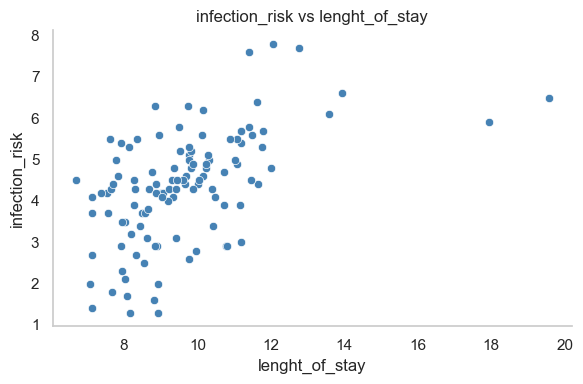

In [39]:
plot_scatterplot(df, 'lenght_of_stay', 'infection_risk')

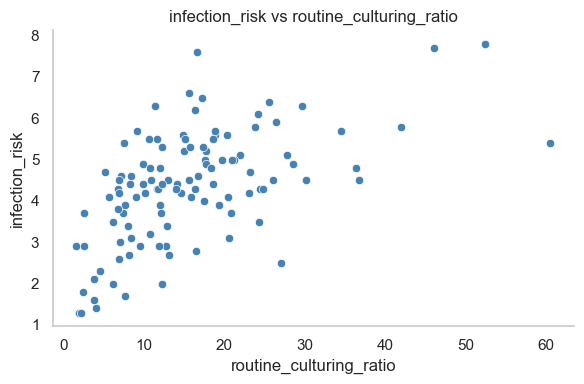

In [40]:
plot_scatterplot(df, 'routine_culturing_ratio', 'infection_risk')

* Analysis: it appears that the relationship between these variables is linear (is it though???? So subjective this)

## Testing linear regression with least squares method

In [41]:
# Dropping categorical columns, while we decide how to deal with them
if 'med_school_affil' in df.columns or 'region' in df.columns:
    df.drop(columns=['med_school_affil', 'region'], inplace=True)

In [42]:
target_variable = 'infection_risk'
# All the variables in the dataset:
y_test, y_prediction = apply_linear_regression(df, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.4843061284030723, 1.0131892734669496)


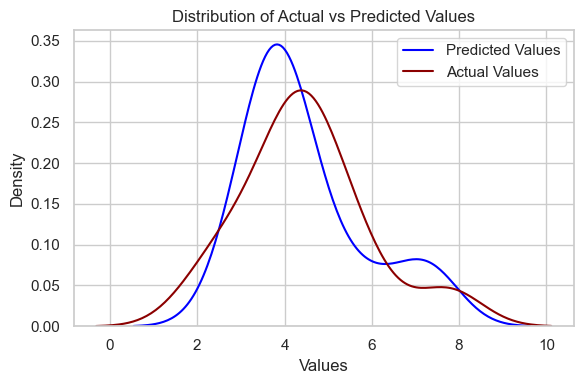

In [43]:
plot_distribution_actual_predicted(y_test, y_prediction)

In [44]:
# Only the highly correlated:
df_slice = df[['infection_risk', 'lenght_of_stay', 'routine_culturing_ratio']].copy()
# print(df.head())
y_test, y_prediction = apply_linear_regression(df_slice, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.5944386252755488, 0.8985099511972287)


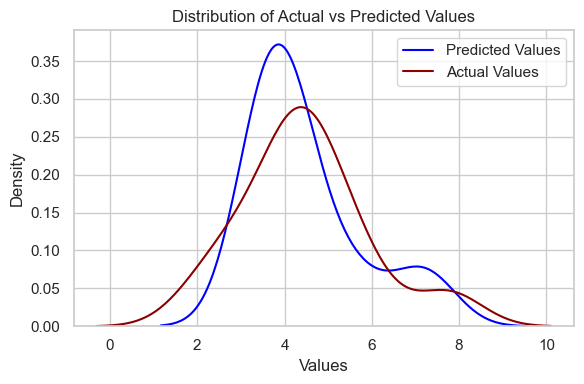

In [45]:
plot_distribution_actual_predicted(y_test, y_prediction)


* Analysis: Both linear regressions do not seem to fit the data well...